In [1]:
import requests
import xml.etree.ElementTree as ET
from matplotlib import pyplot as plt
import numpy as np
import json

In [4]:
coverage_id = "conus_hydro_segments_doy_mmm_maurer"
describe_cov_url = f"https://zeus.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.1.0&REQUEST=DescribeCoverage&COVERAGEID={coverage_id}&outputType=GeneralGridCoverage"

In [5]:
axis_encodings = {}

with requests.get(describe_cov_url) as resp:
    root = ET.fromstring(resp.content)

    # define the namespaces used in the XML
    namespaces = {
        'ras': 'http://www.rasdaman.org',
        'cis11': 'http://www.opengis.net/cis/1.1/gml'
    }
    
    # find the axes section in the metadata
    axes_element = root.find('.//ras:axes', namespaces)
    
    if axes_element is not None:
        for axis in axes_element:
            # get the axis name (remove namespace prefix)
            axis_name = axis.tag.split('}')[-1] if '}' in axis.tag else axis.tag
            
            # find the encoding element for this axis
            encoding_element = axis.find('ras:encoding', namespaces)
            
            if encoding_element is not None:
                # parse the encoding string as a Python dictionary
                encoding_str = encoding_element.text
                try:
                    # convert string representation of dict to actual dict
                    encoding_dict = eval(encoding_str)
                    axis_encodings[axis_name] = encoding_dict
                except:
                    # if eval fails, store as string
                    axis_encodings[axis_name] = encoding_str
    
    print("Axis Encodings:")
    for axis_name, encoding in axis_encodings.items():
        print(f"{axis_name}: {encoding}")


Axis Encodings:
era: {0: '1976-2005', 1: '2016-2045', 2: '2046-2075', 3: '2071-2100'}
landcover: {0: 'dynamic', 1: 'static'}
model: {0: 'access1-0', 1: 'bcc-csm1-1', 2: 'bnu-esm', 3: 'ccsm4', 4: 'gfdl-esm2g', 5: 'gfdl-esm2m', 6: 'ipsl-cm5a-lr', 7: 'ipsl-cm5a-mr', 8: 'maurer', 9: 'miroc-esm', 10: 'miroc-esm-chem', 11: 'miroc5', 12: 'mri-cgcm3', 13: 'noresm1-m'}
scenario: {0: 'historical', 1: 'rcp26', 2: 'rcp45', 3: 'rcp60', 4: 'rcp85'}


In [6]:
# set request params

stream_id = 30488 # upper missouri river
landcover = 1 #'static'

hist_model = 8 #'maurer'
hist_era = 0 #'1976-2005'
hist_scenario = 0 #'historical'

proj_model = 1 #'bcc-csm1-1'
proj_era = 3 #'2071-2100'
proj_scenario = 4 #'rcp85'

In [7]:
get_hist_coverage_url = f"https://zeus.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID={coverage_id}&SUBSET=era({hist_era})&SUBSET=landcover({landcover})&SUBSET=model({hist_model})&SUBSET=scenario({hist_scenario})&SUBSET=stream_id({stream_id})&FORMAT=application/json"
get_proj_coverage_url = f"https://zeus.snap.uaf.edu/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID={coverage_id}&SUBSET=era({proj_era})&SUBSET=landcover({landcover})&SUBSET=model({proj_model})&SUBSET=scenario({proj_scenario})&SUBSET=stream_id({stream_id})&FORMAT=application/json"

In [8]:
with requests.get(get_hist_coverage_url) as resp:
    hist_data = json.loads(resp.content)

    # the response is a list with one element per day, and 3 space separated values per element
    # first element is doy_min, sencond is doy_mean, third is doy_max
    hydrograph_hist_min = []
    hydrograph_hist_mean = []
    hydrograph_hist_max = []

    for day_data in hist_data:
        doy_min, doy_mean, doy_max = map(float, day_data.split())
        hydrograph_hist_min.append(doy_min)
        hydrograph_hist_mean.append(doy_mean)
        hydrograph_hist_max.append(doy_max)


with requests.get(get_proj_coverage_url) as resp:
    proj_data = json.loads(resp.content)

    hydrograph_proj_min = []
    hydrograph_proj_mean = []
    hydrograph_proj_max = []

    for day_data in proj_data:
        doy_min, doy_mean, doy_max = map(float, day_data.split())
        hydrograph_proj_min.append(doy_min)
        hydrograph_proj_mean.append(doy_mean)
        hydrograph_proj_max.append(doy_max)

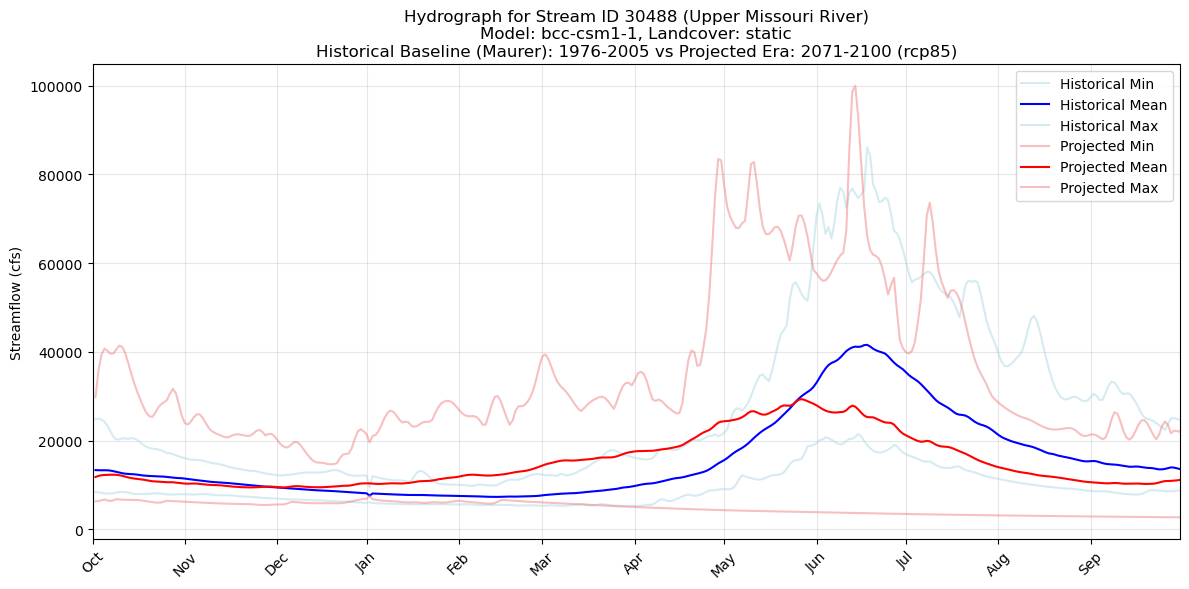

In [10]:
# Create water year ordering: DOY 274-366, then 1-273
# list all doys from 1 to 366
doy_values = np.arange(1, 367)
water_year_order = np.concatenate([
    np.arange(274, 367),  # Oct 1 (274) to Dec 31 (366)
    np.arange(1, 274)     # Jan 1 (1) to Sep 30 (273)
])

# Find the indices to reorder the data
reorder_indices = np.searchsorted(doy_values, water_year_order)

# Create water year DOY axis (1 to 366)
water_year_doy = np.arange(1, len(water_year_order) + 1)

# Convert lists to numpy arrays and reorder
hist_min_ordered = np.array(hydrograph_hist_min)[reorder_indices]
hist_mean_ordered = np.array(hydrograph_hist_mean)[reorder_indices]
hist_max_ordered = np.array(hydrograph_hist_max)[reorder_indices]
proj_min_ordered = np.array(hydrograph_proj_min)[reorder_indices]
proj_mean_ordered = np.array(hydrograph_proj_mean)[reorder_indices]
proj_max_ordered = np.array(hydrograph_proj_max)[reorder_indices]

# Create figure
plt.figure(figsize=(12, 6))

# Plot with properly ordered water year data
plt.plot(water_year_doy, hist_min_ordered, label='Historical Min', linestyle='-', color='lightblue', alpha=0.5)
plt.plot(water_year_doy, hist_mean_ordered, label='Historical Mean', linestyle='-', color='blue')
plt.plot(water_year_doy, hist_max_ordered, label='Historical Max', linestyle='-', color='lightblue', alpha=0.5)
plt.plot(water_year_doy, proj_min_ordered, label='Projected Min', linestyle='-', color='lightcoral', alpha=0.5)
plt.plot(water_year_doy, proj_mean_ordered, label='Projected Mean', linestyle='-', color='red')
plt.plot(water_year_doy, proj_max_ordered, label='Projected Max', linestyle='-', color='lightcoral', alpha=0.5)

# Map numeric codes back to names for title using axis encodings
landcover_name = axis_encodings['landcover'][landcover]
model_name = axis_encodings['model'][proj_model]
scenario_name = axis_encodings['scenario'][proj_scenario]
hist_era_name = axis_encodings['era'][hist_era]
proj_era_name = axis_encodings['era'][proj_era]

plt.title(f'Hydrograph for Stream ID {stream_id} (Upper Missouri River)\nModel: {model_name}, Landcover: {landcover_name}\nHistorical Baseline (Maurer): {hist_era_name} vs Projected Era: {proj_era_name} ({scenario_name})')

# Set x-axis limits and labels for water year
plt.xlim(0, 365)
#plt.xlabel('Days from Start of Water Year (Oct 1 = 0)')
plt.ylabel('Streamflow (cfs)')

# Add month labels for reference
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
# Approximate day of year for start of each month in water year
month_starts = [0, 31, 62, 92, 123, 151, 182, 212, 243, 273, 304, 335]
plt.xticks(month_starts, month_labels, rotation=45)

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()